In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import json
import yaml

# Ensure output directories exist
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Project utilities fallback
try:
    from src.models import MLP
    from src.metrics import OptimizationLogger
    from src.reproducibility import set_seed
    from src.utils import load_config
    print("Successfully imported from src library.")
except ImportError:
    print("src/ not found. Defining core components locally for standalone execution.")

    def set_seed(seed=42):
        torch.manual_seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def load_config(path):
        if os.path.exists(path):
            with open(path, 'r') as f:
                return yaml.safe_load(f)
        return {
            "training": {"batch_size": 64, "epochs": 10},
            "seeds": [0, 1, 2, 3, 4],
            "model": {"input_size": 784, "hidden_size": 128, "output_size": 10},
            "optimizers": {
                "adam": {"lr": 0.001, "weight_decay": 0.0001},
                "adamw": {"lr": 0.001, "weight_decay": 0.0001}
            }
        }

    class MLP(nn.Module):
        def __init__(self, input_size=784, hidden_size=128, output_size=10):
            super().__init__()
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
            )
        def forward(self, x):
            return self.net(x)

    class OptimizationLogger:
        def __init__(self, name="Experiment"):
            self.name = name
            self.logs = {"iteration": [], "objective_value": [], "gradient_norm": [], "elapsed_time": []}
            self.start_time = time.perf_counter()
        def get_summary(self):
            return self.logs

src/ not found. Defining core components locally for standalone execution.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Configuration Management

All hyperparameters (model size, optimizer settings, batch size, epochs, and seeds)
are loaded from an external YAML file to ensure reproducibility and fair benchmarking.

In [3]:
cfg = load_config("configs/nn.yaml")

batch_size = cfg.get("training", {}).get("batch_size", 64)
epochs = cfg.get("training", {}).get("epochs", 10)
seeds = cfg.get("seeds", [0, 1, 2, 3, 4])

adam_cfg = cfg.get("optimizers", {}).get("adam", {})
adamw_cfg = cfg.get("optimizers", {}).get("adamw", {})

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]


In [6]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total

In [8]:
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

In [9]:
def run_experiment(optimizer_name, optimizer_cfg, seed):
    # Reproducibility
    set_seed(seed)

    # Model
    model = MLP(**cfg.get("model", {"hidden_size": 128})).to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(
            model.parameters(),
            lr=optimizer_cfg.get("lr", 1e-3),
            weight_decay=optimizer_cfg.get("weight_decay", 1e-4)
        )
    else:
        optimizer = optim.AdamW(
            model.parameters(),
            lr=optimizer_cfg.get("lr", 1e-3),
            weight_decay=optimizer_cfg.get("weight_decay", 1e-4)
        )

    # Logger
    logger = OptimizationLogger(name=f"{optimizer_name}_seed_{seed}")
    logger.logs["test_accuracy"] = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_grad_norms = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()

            epoch_grad_norms.append(compute_grad_norm(model))
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        mean_grad_norm = float(np.mean(epoch_grad_norms))
        test_acc = evaluate(model, test_loader)

        logger.logs["iteration"].append(epoch)
        logger.logs["objective_value"].append(epoch_loss)
        logger.logs["gradient_norm"].append(mean_grad_norm)
        logger.logs["test_accuracy"].append(test_acc)
        logger.logs["elapsed_time"].append(time.perf_counter() - logger.start_time)

        print(f"{optimizer_name} | seed {seed} | epoch {epoch+1}/{epochs} | loss={epoch_loss:.4f} | acc={test_acc:.4f}")

    return logger.get_summary()

In [10]:
adam_results = []
adamw_results = []

for s in seeds:
    print(f"Running Adam with seed {s}...")
    adam_results.append(run_experiment("Adam", adam_cfg, s))
    print(f"Running AdamW with seed {s}...")
    adamw_results.append(run_experiment("AdamW", adamw_cfg, s))

Running Adam with seed 0...
Adam | seed 0 | epoch 1/10 | loss=0.2563 | acc=0.9615
Adam | seed 0 | epoch 2/10 | loss=0.1151 | acc=0.9706
Adam | seed 0 | epoch 3/10 | loss=0.0803 | acc=0.9753
Adam | seed 0 | epoch 4/10 | loss=0.0616 | acc=0.9665
Adam | seed 0 | epoch 5/10 | loss=0.0517 | acc=0.9765
Adam | seed 0 | epoch 6/10 | loss=0.0412 | acc=0.9775
Adam | seed 0 | epoch 7/10 | loss=0.0364 | acc=0.9705
Adam | seed 0 | epoch 8/10 | loss=0.0324 | acc=0.9774
Adam | seed 0 | epoch 9/10 | loss=0.0279 | acc=0.9769
Adam | seed 0 | epoch 10/10 | loss=0.0241 | acc=0.9786
Running AdamW with seed 0...
AdamW | seed 0 | epoch 1/10 | loss=0.2562 | acc=0.9630
AdamW | seed 0 | epoch 2/10 | loss=0.1149 | acc=0.9708
AdamW | seed 0 | epoch 3/10 | loss=0.0791 | acc=0.9731
AdamW | seed 0 | epoch 4/10 | loss=0.0612 | acc=0.9704
AdamW | seed 0 | epoch 5/10 | loss=0.0486 | acc=0.9747
AdamW | seed 0 | epoch 6/10 | loss=0.0393 | acc=0.9779
AdamW | seed 0 | epoch 7/10 | loss=0.0327 | acc=0.9760
AdamW | seed 0 | 

## Adam vs AdamW: Weight Decay in Adaptive Methods

Standard Adam implements regularization as L2 penalty added to the gradient, which
interacts incorrectly with adaptive learning rates. AdamW decouples weight decay from
the gradient update, applying it directly to the parameters.

Loshchilov and Hutter (2019) showed that AdamW restores the intended behavior of weight
decay, leading to improved generalization.

In [11]:
def summarize(results):
    final_losses = [r["objective_value"][-1] for r in results]
    return np.mean(final_losses), np.std(final_losses)

adam_mean, adam_std = summarize(adam_results)
adamw_mean, adamw_std = summarize(adamw_results)

print(f"Adam   Final Loss: {adam_mean:.4f} ± {adam_std:.4f}")
print(f"AdamW  Final Loss: {adamw_mean:.4f} ± {adamw_std:.4f}")

Adam   Final Loss: 0.0251 ± 0.0008
AdamW  Final Loss: 0.0194 ± 0.0012


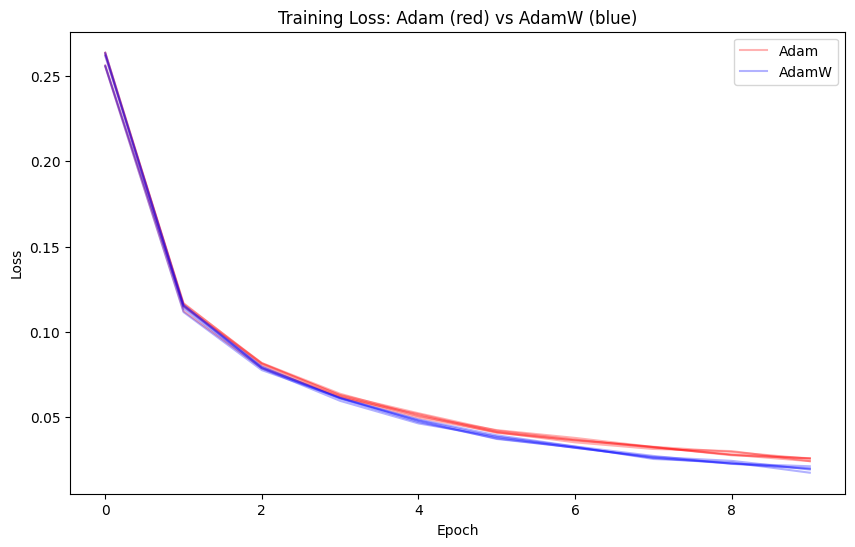

Results saved to results/nn_results.json


In [12]:
plt.figure(figsize=(10, 6))
for r in adam_results:
    plt.plot(r["objective_value"], color="red", alpha=0.3, label="Adam" if r == adam_results[0] else "")
for r in adamw_results:
    plt.plot(r["objective_value"], color="blue", alpha=0.3, label="AdamW" if r == adamw_results[0] else "")

plt.title("Training Loss: Adam (red) vs AdamW (blue)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("figures/nn_training_curves.png")
plt.show()

# Final result saving
final_data = {
    "adam_losses": [r["objective_value"][-1] for r in adam_results],
    "adamw_losses": [r["objective_value"][-1] for r in adamw_results],
    "adam_accs": [r["test_accuracy"][-1] for r in adam_results],
    "adamw_accs": [r["test_accuracy"][-1] for r in adamw_results]
}
with open("results/nn_results.json", "w") as f:
    json.dump(final_data, f, indent=4)
print("Results saved to results/nn_results.json")